In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import argparse
import sys
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

from CustomDatasets import MagnetDataset
from Unet_MaxProkop import UNet
from Trainer import Trainer


In [93]:

train_set = MagnetDataset("../Stage_magnet", (0,0.60),maximum_elements=8)
val_set = MagnetDataset("../Stage_magnet", (0.60,0.80),maximum_elements=8)

train_loader = DataLoader(train_set,batch_size=8)
val_loader = DataLoader(val_set,batch_size=8)

print(train_set[0][0].shape)
print(train_set[0][1].shape)


(3, 120, 80)
(2, 120, 80)


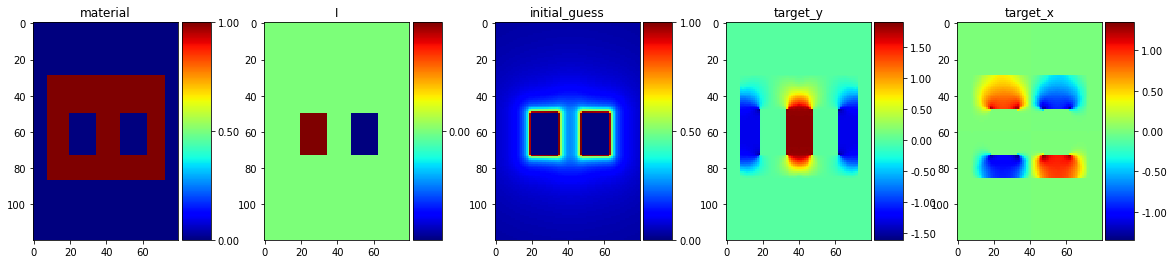

In [86]:
idx = 2
sample=val_set[idx]

fig, axes = plt.subplots(1,5,figsize=(20,4))

for i, name, image in zip(range(5),["material","I","initial_guess","target_y","target_x"], [sample[0][0,:,:],sample[0][1,:,:],sample[0][2,:,:],sample[1][0,:,:],sample[1][1,:,:]]):
    im = axes[i].imshow(image, cmap='jet',interpolation='none')
    axes[i].set_title(name)

    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")



In [79]:
sample[0][0,:,:][60,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

First takeaway: improve initial guess

Split up initial guess into x and y component

In [101]:
#Create model
model = UNet(in_channels=3,out_channels=2,depth=4)

In [102]:
#Create Trainer

trainer_parameters = {
    "optimizer": optim.Adam,
    "optimizer_parameters": {
        "lr":1e-4
    },
    "loss_fun":nn.MSELoss,
    "device":torch.device('cpu'),
    "model":model,
    "train_dataloader":train_loader,
    "val_dataloader":val_loader,
    "num_epochs": 100
}

trainer = Trainer(**trainer_parameters)

In [103]:
train_hist,val_hist = trainer.train()

	 Epoch 1:	 Train_loss: 0.2073	 Val_loss: 0.1827	8:22:7:0
	 Epoch 2:	 Train_loss: 0.2072	 Val_loss: 0.1826	8:22:7:7
	 Epoch 3:	 Train_loss: 0.2071	 Val_loss: 0.1825	8:22:7:15
	 Epoch 4:	 Train_loss: 0.2070	 Val_loss: 0.1824	8:22:7:23
	 Epoch 5:	 Train_loss: 0.2069	 Val_loss: 0.1823	8:22:7:32
	 Epoch 6:	 Train_loss: 0.2068	 Val_loss: 0.1823	8:22:7:41
	 Epoch 7:	 Train_loss: 0.2067	 Val_loss: 0.1821	8:22:7:50
	 Epoch 8:	 Train_loss: 0.2066	 Val_loss: 0.1820	8:22:7:59
	 Epoch 9:	 Train_loss: 0.2065	 Val_loss: 0.1819	8:22:8:8
	 Epoch 10:	 Train_loss: 0.2063	 Val_loss: 0.1818	8:22:8:18
	 Epoch 11:	 Train_loss: 0.2062	 Val_loss: 0.1816	8:22:8:27
	 Epoch 12:	 Train_loss: 0.2060	 Val_loss: 0.1815	8:22:8:36
	 Epoch 13:	 Train_loss: 0.2059	 Val_loss: 0.1813	8:22:8:45
	 Epoch 14:	 Train_loss: 0.2057	 Val_loss: 0.1812	8:22:8:54
	 Epoch 15:	 Train_loss: 0.2055	 Val_loss: 0.1810	8:22:9:3
	 Epoch 16:	 Train_loss: 0.2053	 Val_loss: 0.1808	8:22:9:12
	 Epoch 17:	 Train_loss: 0.2051	 Val_loss: 0.1806	8:2

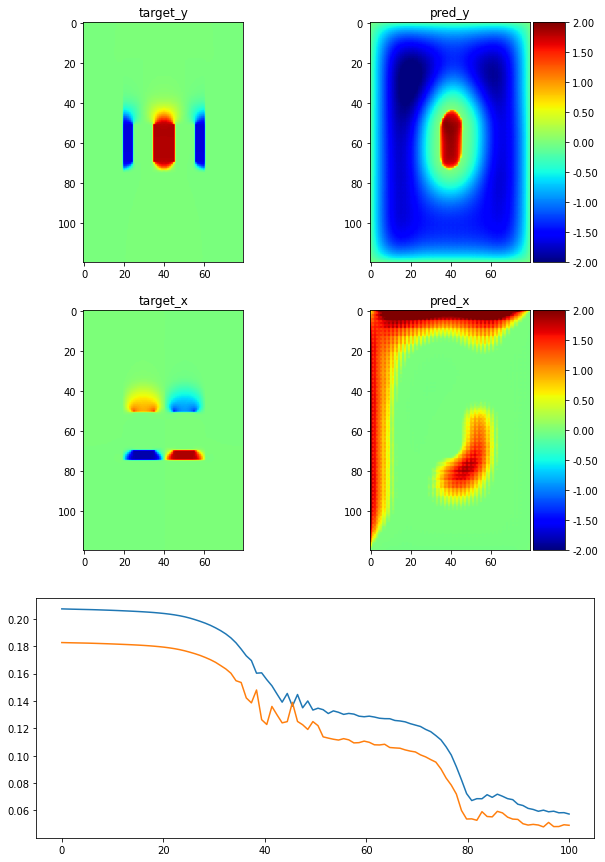

In [104]:
idx = 0
sample=train_set[idx]

fig, axes = plt.subplots(3,2,figsize=(10,15))

gs = axes[2, 0].get_gridspec()
axes[2,0].remove()
axes[2,1].remove()
axbig = fig.add_subplot(gs[2, 0:])

im0 = axes[0][0].imshow(sample[1][0,:,:],vmin=-2, vmax=2, cmap='jet')
axes[0][0].set_title("target_y")
im1 = axes[1][0].imshow(sample[1][1,:,:],vmin=-2, vmax=2, cmap='jet')
axes[1][0].set_title("target_x")

prediction = model(torch.tensor(sample[0]).unsqueeze(0).float()).squeeze().detach().numpy() 

im2 = axes[0][1].imshow(prediction[0,:,:],vmin=-2, vmax=2, cmap='jet')
axes[0][1].set_title("pred_y")
im3 = axes[1][1].imshow(prediction[1,:,:],vmin=-2, vmax=2, cmap='jet')
axes[1][1].set_title("pred_x")

divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")

divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")


x = np.linspace(0, 100, 100)
axbig.plot(x, train_hist)
axbig.plot(x, val_hist)


